# Classification using Meta Labelling and a Trend Following Strategy

This notebook develops Exercise 3.4 proposed in AFML

1. Develop a trend-following strategy (eg. crossing MAs) to get the side of each possible trade
2. Derive metalabels for an asymmetric position (2,1) and a daily vertical barrier. The target has to be the daily standard deviation.
3. Train a random forest (classifier) to decide wheater to trade or not {0,1}. Note the exogenous primary model will indeed decide the side {-1,1}

For this specific application I could not find futures data with timeframes lower than daily. We will spice it up with my lovely BTC 1h timeframe dataset spanning from 2018 to 2025. 

The dataset is continous as crypto trade 24/7 and will be of around 60k observations (manageble size).

let's DIVE IN!

In [33]:
#general purpose imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

#specific imports
scripts_path = Path("../00_books/AFML/scripts").resolve()
sys.path.append(str(scripts_path))
from AFML_book_scripts import *
from AFML_my_scripts import *

## Data

### Import and Check

In [34]:
#import data
data = pd.read_csv('../00_books/AFML/data/btc_1h_data_2018_to_2025.csv')
#dataframe them
df = pd.DataFrame(data)
#keep only colums we need
df = df[['Close time', 'Open', 'High', 'Low', 'Close', 'Volume']]
#rename the columns
df = df.rename(columns={
    'Close time': 'timestamp',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})
#round the time to the nearest hour (it like 59 mminutes, 59 seconds and 999 milliseconds --> 1 hour)
# and transform the timestamp to datetime
df = df.set_index(pd.to_datetime(df['timestamp']))
# set the index to the timestamp and drop the original timestamp column
df = df.drop(columns=['timestamp'])
df.index = df.index.round('H')
df.head()

C:\Users\dgalassi\AppData\Local\Temp\ipykernel_23024\1888112713.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = df.index.round('H')


,open,high,low,close,volume
timestamp,,,,,
2018-01-01 01:00:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 02:00:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 03:00:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 04:00:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 05:00:00,13434.98,13623.29,13322.15,13601.01,340.807329


In [35]:
#before going on lets check if we have any missing values
print(f"Missing values in the dataframe: {df.isnull().sum().sum()}")
#check if we have any duplicate rows
print(f"Duplicate rows in the dataframe: {df.duplicated().sum()}")
#check the data types of the columns
print(f"Data types of the columns:\n{df.dtypes}")
#check the main statistics of the dataframe
print("Main statistics of the dataframe")
df.describe()

Missing values in the dataframe: 0
Duplicate rows in the dataframe: 0
Data types of the columns:
open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object
Main statistics of the dataframe


,open,high,low,close,volume
count,64246.000000,64246.000000,64246.000000,64246.000000,64246.000000
mean,31051.036873,31189.717382,30905.784666,31052.287485,2899.294781
std,25503.916438,25605.076599,25400.640074,25505.037132,4097.290365
min,3172.620000,3184.750000,3156.260000,3172.050000,0.000000
25%,9174.257500,9210.000000,9141.062500,9174.575000,936.093341
50%,23792.930000,23895.065000,23684.615000,23794.135000,1603.616266
75%,46636.522500,46883.825000,46346.672500,46639.797500,3061.447620
max,108320.000000,109588.000000,107780.510000,108320.010000,137207.188600


### Statistical/Microstructure Consideration

**IMPORTANT COMMENT!!!**

Here we have two options:
1. Keep the data in this format --> time bars --> much easier to work with 
2. Transform the data into volume/dollar bars --> better statistical properties but messier to work with

So which one shall we pick?

Normally speaking volume/dollars bars are better because they have better statistical properties:
- Activity normalization (heteroskedasticity) --> grouping by vol/dol removes activity peaks and dumps 
- Greater microstrucutre information
- Less noisy for meta-labelling

This is true and stated. BUT... here we deal with cryptos... so what?

Well I expect that activity is more spread along the hours (always open market) hence this effect should be already weaker. We can verify it and eventually (if needed) also work with a logaritmic transformation.

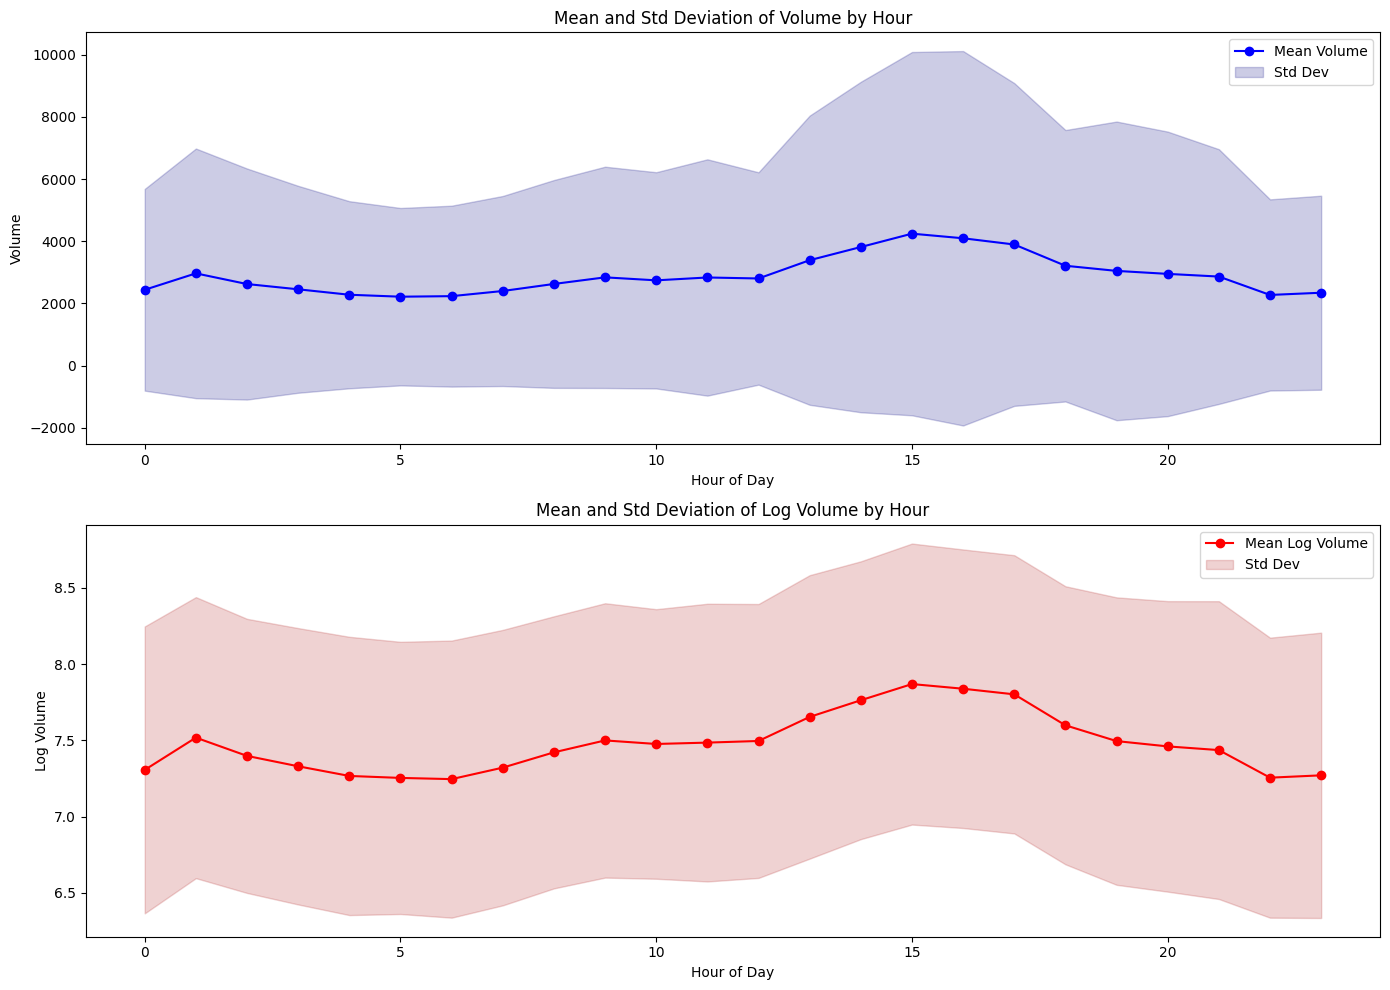

In [37]:
df['hour'] = df.index.hour
df['log_volume'] = np.log(df['volume'] + 1)  # Adding 1 to avoid log(0)
hourly_mean_volume = df.groupby('hour')['volume'].mean()
hourly_std_volume = df.groupby('hour')['volume'].std()
hourly_mean_log_volume = df.groupby('hour')['log_volume'].mean()
hourly_std_log_volume = df.groupby('hour')['log_volume'].std()

#create a grid for the plots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
# Plotting mean and std deviation of volume
axs[0].plot(hourly_mean_volume, label='Mean Volume', marker='o', color='blue')
axs[0].fill_between(hourly_mean_volume.index,
                 hourly_mean_volume - hourly_std_volume, 
                 hourly_mean_volume + hourly_std_volume, 
                 color='navy', alpha=0.2, label='Std Dev')
# Plotting mean and std deviation of log volume
axs[1].plot(hourly_mean_log_volume, label='Mean Log Volume', marker='o', color='red')
axs[1].fill_between(hourly_mean_log_volume.index,
                 hourly_mean_log_volume - hourly_std_log_volume, 
                 hourly_mean_log_volume + hourly_std_log_volume, 
                 color='firebrick', alpha=0.2, label='Std Dev')

# Setting titles and labels
axs[0].set_title('Mean and Std Deviation of Volume by Hour')    
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Volume')
axs[0].legend()
axs[1].set_title('Mean and Std Deviation of Log Volume by Hour')    
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Log Volume')
axs[1].legend()
plt.tight_layout()
plt.show()

**RESULTS?**

I don't see a clear pattern here. Other than a peak occurring around 3pm the volume is quite steady and the log transormation is not eveually needed as the volume distribution per hour of the day is quite smooth.

--> For this analysis I consider my hypothesis quite reasonable --> we can use hourly tick data

In [38]:
#drop the columns we don't need anymore
df = df.drop(columns=['hour', 'log_volume'])

## Trend Following Strategy